In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow_datasets as tfds
from tensorflow.data.experimental import sample_from_datasets
from keras.layers import Activation, Dense, Dropout

tfkl = tfk.layers

**Preprocessing**

As typical, we'll start with the MNIST data. Recall from last time, we have to do some transformations and preprocessing on these images.

In [2]:
data, info = tfds.load('mnist', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
preprocess = lambda d: (tf.cast(d["image"], tf.float32)/255, tf.one_hot(d["label"], depth=10))

ds_train = data["train"].map(preprocess).cache().batch(32)
ds_test = data["test"].map(preprocess).cache().batch(32)

In [4]:
img_shape = info.features['image'].shape

In [5]:
img_shape

(28, 28, 1)

**CNNs in TF Keras**

We'll use the Sequential class rely on new layer types that correspond to concepts we covered in lecture: Conv2D, AvgPool2D, MaxPool2D. 

Details such as kernel size, padding, strides and so on must be specified as args to these classes, where appropriate.

In [6]:
model = tfk.Sequential()
model.add(tfkl.Conv2D(filters = 1, kernel_size=(3,3), strides=(1,1), 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(4,4)))
model.add(tfkl.Flatten())
model.add(tfkl.Dense(10, activation='softmax'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 1)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 6, 6, 1)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                370       
Total params: 380
Trainable params: 380
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(ds_train, steps_per_epoch=20, epochs=20, validation_data=ds_test)

Epoch 1/20
20/20 [==============================] - 3s 141ms/step - loss: 2.2956 - val_loss: 2.2912
Epoch 2/20
20/20 [==============================] - 1s 74ms/step - loss: 2.2910 - val_loss: 2.2802
Epoch 3/20
20/20 [==============================] - 2s 75ms/step - loss: 2.2784 - val_loss: 2.2671
Epoch 4/20
20/20 [==============================] - 2s 76ms/step - loss: 2.2670 - val_loss: 2.2518
Epoch 5/20
20/20 [==============================] - 2s 76ms/step - loss: 2.2510 - val_loss: 2.2326
Epoch 6/20
20/20 [==============================] - 2s 75ms/step - loss: 2.2347 - val_loss: 2.2110
Epoch 7/20
20/20 [==============================] - 2s 78ms/step - loss: 2.2017 - val_loss: 2.1849
Epoch 8/20
20/20 [==============================] - 2s 76ms/step - loss: 2.1916 - val_loss: 2.1571
Epoch 9/20
20/20 [==============================] - 2s 76ms/step - loss: 2.1459 - val_loss: 2.1233
Epoch 10/20
20/20 [==============================] - 2s 77ms/step - loss: 2.1246 - val_loss: 2.0874
Epoch 11

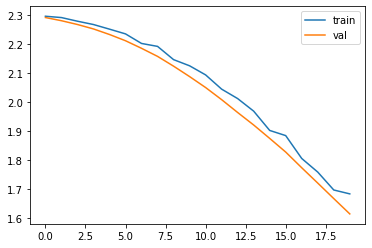

In [9]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Probability')

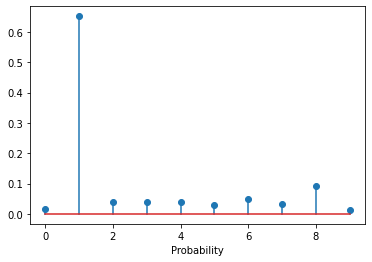

In [10]:
plt.stem(model.predict(ds_test.take(1))[9, :])
plt.xlabel("Digit")
plt.xlabel("Probability")

Which architectural hyperparameters might we change in the above?



**Exercise - Deep CNN**

Build and fit your own CNN model with 3 convolutional **modules**, where each one contains:
  * kernel convolution 
    * you pick number of kernels
    * you pick kernel shape/size
    * you pick activation
  * pooling
  * dropout

We'll use the Fashion MNIST dataset, a low-res collection of images of clothing.

In [11]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
images = images[:, :, :, np.newaxis]
labels = tf.one_hot(labels.astype(np.int32),10)

# optional - TF Datasets objects
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)


#Test_data
images1, labels1 = test
images1 = images1/255.0
images1 = images1[:, :, :, np.newaxis]
labels1 = tf.one_hot(labels1.astype(np.int32),10)

fmnist_test_ds = tf.data.Dataset.from_tensor_slices((images1, labels1))
fmnist_test_ds = fmnist_test_ds.shuffle(5000).batch(32)


4423680/4422102 [==============================] - 0s 0us/step


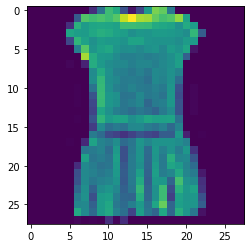

In [12]:
plt.imshow(images[3, :, :, :].squeeze())

In [13]:
model = tfk.Sequential()

# Block 1
model.add(tfkl.Conv2D(filters = 1, kernel_size= 2, strides= 2, 
                      padding="valid", activation='relu', input_shape=(28, 28, 1)))
model.add(tfkl.MaxPool2D(pool_size=(2)))
model.add(Dropout(0.2))

# Block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size= 2, strides= 1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2)))
model.add(Dropout(0.2))

# Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size= 2, strides= 1, 
                      padding="valid", activation='relu'))
model.add(tfkl.MaxPool2D(pool_size=(2)))
model.add(Dropout(0.2))

# Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(10, activation='softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 1)         5         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 1)           0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 16)          80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 3, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 8)          

In [15]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(),
    loss=tfk.losses.CategoricalCrossentropy(),
)

results = model.fit(fmnist_train_ds,batch_size=32,steps_per_epoch=20, epochs=20,validation_data=fmnist_test_ds)

Epoch 1/20
20/20 [==============================] - 1s 41ms/step - loss: 2.3010 - val_loss: 2.2985
Epoch 2/20
20/20 [==============================] - 1s 39ms/step - loss: 2.2968 - val_loss: 2.2941
Epoch 3/20
20/20 [==============================] - 1s 39ms/step - loss: 2.2875 - val_loss: 2.2862
Epoch 4/20
20/20 [==============================] - 1s 41ms/step - loss: 2.2797 - val_loss: 2.2756
Epoch 5/20
20/20 [==============================] - 1s 40ms/step - loss: 2.2685 - val_loss: 2.2617
Epoch 6/20
20/20 [==============================] - 1s 40ms/step - loss: 2.2490 - val_loss: 2.2428
Epoch 7/20
20/20 [==============================] - 1s 39ms/step - loss: 2.2188 - val_loss: 2.2158
Epoch 8/20
20/20 [==============================] - 1s 39ms/step - loss: 2.1938 - val_loss: 2.1886
Epoch 9/20
20/20 [==============================] - 1s 39ms/step - loss: 2.1821 - val_loss: 2.1642
Epoch 10/20
20/20 [==============================] - 1s 41ms/step - loss: 2.1575 - val_loss: 2.1383
Epoch 11/

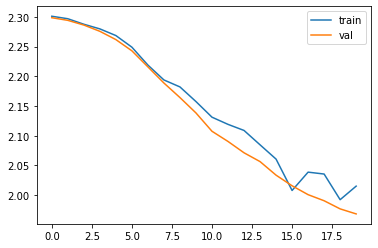

In [16]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["train", "val"])


#|**Exercise - Transfer Learning**



In [17]:
data, info = tfds.load('rock_paper_scissors', with_info=True)
train_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.one_hot(x["label"], depth=3))).batch(32)
test_data = data["train"].map(lambda x: (tf.cast(x["image"], tf.float32) / 255., tf.one_hot(x["label"], depth=3))).batch(32)

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteVT9M7D/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteVT9M7D/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [18]:
info.features['image'].shape

(300, 300, 3)

,image,label
0,,2 (scissors)
1,,2 (scissors)
2,,0 (rock)
3,,1 (paper)
4,,0 (rock)
5,,1 (paper)
6,,2 (scissors)
7,,1 (paper)
8,,2 (scissors)
9,,2 (scissors)

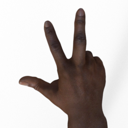
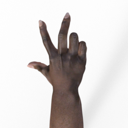
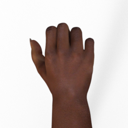
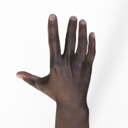
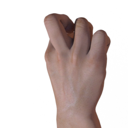
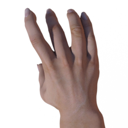
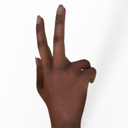
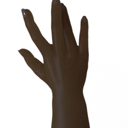
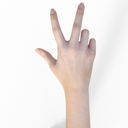
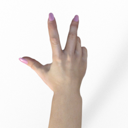

In [19]:
tfds.as_dataframe(data["train"].take(10), info)

# Exercise

1. Build a deep CNN model and train it for this binary classification task. Fit the model using the small dataset of 500 samples, *train_data*.

What accuracy can your model acheive on the training data?

In [20]:
rocks_train = data["train"].take(500)
rocks_train = rocks_train.map(lambda x: (tf.cast(x["image"], tf.float32) / 255.,tf.one_hot(x["label"], depth=3))).batch(32)

In [21]:
#Seperating labels and images
train_images, train_labels = next(iter(rocks_train))
test_images, test_labels = next(iter(test_data))

In [22]:
train_images.shape

TensorShape([32, 300, 300, 3])

In [23]:
 model = tfk.Sequential()

 model.add(tfkl.Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [300,300, 3]))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Conv2D(64, 3, padding='same', kernel_initializer='he_uniform',activation='relu'))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Conv2D(128, 3, padding='same', kernel_initializer='he_uniform',activation='relu'))
 model.add(tfkl.MaxPooling2D(2))

 model.add(tfkl.Flatten())
 model.add(tfkl.Dense(128, kernel_initializer='he_uniform',activation = 'relu'))
 model.add(tfkl.Dense(3, activation = 'softmax'))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 128)      

In [25]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1,  horizontal_flip=True)
it_gen = datagen.flow(train_images, train_labels, batch_size=32)

#The above code will create random images of different variation depending on the parameter that was set. for instance we set horizontal_flip as True 
#this means that some images will be flipped horizontally

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


steps = int(train_images.shape[0] / 32)
results = model.fit(it_gen,epochs = 20,steps_per_epoch=steps, validation_data = (test_images, test_labels))

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 1.3929 - accuracy: 0.2812 - val_loss: 25.6075 - val_accuracy: 0.4688
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 25.5081 - accuracy: 0.4688 - val_loss: 13.6847 - val_accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 13.4867 - accuracy: 0.2500 - val_loss: 5.4161 - val_accuracy: 0.2500
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 5.3462 - accuracy: 0.2500 - val_loss: 3.2544 - val_accuracy: 0.4688
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 3.3554 - accuracy: 0.4688 - val_loss: 1.5451 - val_accuracy: 0.4688
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 1.5699 - accuracy: 0.4688 - val_loss: 1.1633 - val_accuracy: 0.2812
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 1.1870 - accuracy: 0.2812 - val_loss: 1.1697 - val_accuracy: 0.2812
Epoch 8/20
1/1 [=====================

 2. Now use transfer learning by incorporating the pretrained VGG16 model.

In [27]:
from tensorflow.keras.applications import VGG16

In [28]:
conv_base = VGG16(weights="imagenet",include_top=False,input_shape=(300,300,3))

58892288/58889256 [==============================] - 1s 0us/step


In [29]:
model = tfk.Sequential()

model.add(conv_base)

for layer in model.layers:
    layer.trainable = False

model.add(tfkl.Flatten())
model.add(tfkl.Dense(3, activation = 'softmax'))

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 124419    
Total params: 14,839,107
Trainable params: 124,419
Non-trainable params: 14,714,688
_________________________________________________________________


In [31]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_gen = datagen.flow(train_images, train_labels, batch_size=32)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


steps = int(train_images.shape[0] / 32)
results = model.fit(it_gen,epochs = 20,steps_per_epoch=steps, validation_data = (test_images, test_labels))

Epoch 1/20
1/1 [==============================] - 28s 28s/step - loss: 1.2306 - accuracy: 0.4688 - val_loss: 4.2836 - val_accuracy: 0.4062
Epoch 2/20
1/1 [==============================] - 28s 28s/step - loss: 4.4054 - accuracy: 0.4062 - val_loss: 2.5762 - val_accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 28s 28s/step - loss: 2.7777 - accuracy: 0.3125 - val_loss: 0.5007 - val_accuracy: 0.7188
Epoch 4/20
1/1 [==============================] - 28s 28s/step - loss: 0.5395 - accuracy: 0.8438 - val_loss: 1.6908 - val_accuracy: 0.4688
Epoch 5/20
1/1 [==============================] - 28s 28s/step - loss: 1.6607 - accuracy: 0.4688 - val_loss: 1.4123 - val_accuracy: 0.6250
Epoch 6/20
1/1 [==============================] - 28s 28s/step - loss: 1.5769 - accuracy: 0.5000 - val_loss: 1.0248 - val_accuracy: 0.7500
Epoch 7/20
1/1 [==============================] - 28s 28s/step - loss: 1.2760 - accuracy: 0.7500 - val_loss: 0.7333 - val_accuracy: 0.6562
Epoch 8/20
1/1 [===========